# Test the difference resulting from putting source terms at different places
1, Poisson only 

2, Perpendicular Ampere's law only

3, Both

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from gk_solver.gk_apar0 import dispersion, res_0, res_i
from gk_solver.util import real_imag, list2complex
%matplotlib inline

### Functions to construct time series easily

In [2]:
def ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                   wbar_0, wbar_arr, tbar_arr, turnoff=None):
    """
    return time series for B_parallel and phi
    """
    
    def phi_b(tbar):
        """
            vector(\phi(t), B(t))
    """
        res = res_0(ti_te, mi_me, bi, kperp_rhoi, wbar_0, tbar, turnoff=turnoff)
        for wbar_i in wbar_arr:
            res += res_i(ti_te, mi_me, bi, kperp_rhoi, wbar_0, wbar_i, tbar, turnoff=turnoff)
        return res
    
    phi_b_arr = np.array([phi_b(tbar) for tbar in tbar_arr])
    return phi_b_arr

In [3]:
def eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi):
    """
    find the eigenmodes of the gk system.
    currently hard coded the initial values for beta_i << 1, Ti = Te.
    """
    # slow mode
    guess_sm_1 = np.sqrt(bi) * 1.4 * (1-0.5j)
    guess_sm_2 = np.sqrt(bi) * 1.4 * (-1-0.5j)
    # entropy mode
    guess_sm_3 = (-0.2 * np.log10(bi) -0.58) * 1j

    f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))
    wbar_arr = []
    for guess in [guess_sm_1, guess_sm_2, guess_sm_3]:
        res = scipy.optimize.fsolve(f, real_imag(guess))
        wbar = list2complex(res)
        if np.abs(wbar.real) < 1.e-10:
            wbar = 1j * wbar.imag
        wbar_arr += [wbar]
    return wbar_arr

Parameters setup

In [10]:
ti_te = 0.01
kperp_rhoi = 0.2
wbar_0 = 0.5
tf_arr = [None, 'poisson', 'ampere']
bi = 0.01
bpar0 = 10
mi_me = 1836

texts = "{0}{1}\n".format(r'$\beta_i$=',bi) + \
    "{0}{1}\n".format(r'$T_i/T_e=$',ti_te) + \
    "{0}{1}\n".format(r'$k_\perp \rho_i=$',kperp_rhoi) + \
    "{0}{1}\n".format(r'$\delta B_{\mathbf{k}\parallel 0}=$', bpar0) +\
    "{0}{1}\n".format(r'$\overline{\omega}_0=$', wbar_0)


Eigenmodes / simple poles

In [11]:
wbar_arr = eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi)
print(wbar_arr)

[(0.39692062237700992-0.0020940512930690473j), (-0.39692062237702253-0.0020940512930693422j), (-0-0.1851598067603516j)]


In [12]:
tbar_arr = np.linspace(0, 100, 500)

In [13]:
phi_bpar_arr = np.array([ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                                        wbar_0, wbar_arr, tbar_arr, turnoff=tf) 
 for tf in tf_arr])

In [14]:
phi_arr = np.abs(phi_bpar_arr[:, :, 0])
bpar_arr = np.abs(phi_bpar_arr[:,:,1])

Make $\phi(t)$ plot

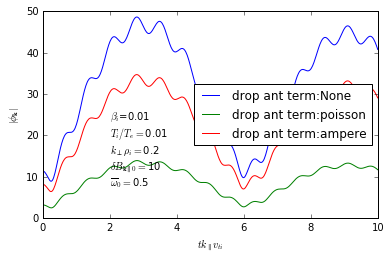

In [15]:
fig_phi_tf = plt.figure(figsize=[6, 6*0.618])
for i in range(len(tf_arr)):
    plt.plot(tbar_arr * np.sqrt(bi), phi_arr[i, :]*bpar0, 
             label = '{0}{1}'.format('drop ant term:', str(tf_arr[i])))
plt.legend(loc='center right')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\phi_{\mathbf{k}}|$')
ax = plt.gca()
plt.text(0.2, 0.1, texts, transform=ax.transAxes,)
plt.show()

make $B_\parallel$ plot

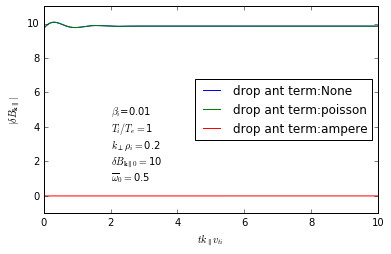

In [18]:
fig_bpar_tf = plt.figure(figsize=[6, 6*0.618])
for i in range(len(tf_arr)):
    plt.plot(tbar_arr * np.sqrt(bi), bpar_arr[i, :]*bpar0, 
             label = '{0}{1}'.format('drop ant term:', str(tf_arr[i])))
plt.ylim([-1, 11])    
plt.legend(loc='center right')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\delta B_{\mathbf{k}\parallel}|$')
ax = plt.gca()
plt.text(0.2, 0.1, texts, transform=ax.transAxes,)
plt.show()

In [11]:
# fig_phi_tf.savefig('fig_phi_tf.eps')
# fig_bpar_tf.savefig('fig_bpar_tf.eps')